In [1]:
import numpy as np
import matplotlib.pyplot as plt
from operator import add
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import gym
from tqdm import tqdm

In [94]:
class Actor_Network(nn.Module):

    def __init__(self, input_size, output_size, path = 'models/'):
        super(Actor_Network, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.layer1 = nn.Linear(input_size, 256).to(self.device)
        self.layer2 = nn.Linear(256, 128).to(self.device)
        # self.layer3 = nn.Linear(64, 64).to(self.device)
        self.layer3 = nn.Linear(128, output_size).to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
        self.path = path
        self.to(self.device)
        
        
    def forward(self, x):
        x = x.to(self.device)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # x = F.relu(self.layer3(x))
        output = F.softmax(self.layer3(x), dim = 1)
        return output
        
    def save_model(self,filename='a2c_actor.pth'):
        torch.save(self.state_dict(), self.path+filename)

    def load_model(self,filename='a2c_actor.pth'):
        self.load_state_dict(torch.load(self.path+filename))


In [95]:
class Critic_Network(nn.Module):

    def __init__(self, input_size, output_size = 1, path = 'models/'):
        super(Critic_Network, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.layer1 = nn.Linear(input_size, 256).to(self.device)
        self.layer2 = nn.Linear(256, 128).to(self.device)
        # self.layer3 = nn.Linear(64, 64).to(self.device)
        self.layer3 = nn.Linear(128, output_size).to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
        self.path = path
        self.to(self.device)
        
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # x = F.relu(self.layer3(x))
        output = self.layer3(x)
        return output
        
    def save_model(self,filename='a2c_critic.pth'):
        torch.save(self.state_dict(), self.path+filename)

    def load_model(self,filename='a2c_critic.pth'):
        self.load_state_dict(torch.load(self.path+filename))

In [109]:
class A2C_acrobot:
    def __init__(self, env_variable, env_type, input_size, output_size):
        self.training_episodes = 3000
        self.discount_factor = 0.99
        self.env = env_variable
        self.actor_network = Actor_Network(input_size, output_size)
        self.critic_network = Critic_Network(input_size, 1)
        self.env_type = env_type
        self.input_size = input_size
        self.output_size = output_size
        
    def select_action(self, observation):
        obs = torch.tensor([observation]).to(self.actor_network.device).float()
        probs = self.actor_network.forward(obs)
        actions_probabilities = torch.distributions.Categorical(probs)
        action = actions_probabilities.sample()
        log_probability = actions_probabilities.log_prob(action)
        return action.cpu().detach().numpy()[0], log_probability
    
    def main(self):

        count = 0
        total_rewards_array = []
        all_time_steps = []
        epsilons = []
        for epi in tqdm(range(self.training_episodes)):
            total_reward = 0
            current_state = self.env.reset()
            done = False
            timestep_count = 0
            count +=1
            while not done:
                timestep_count += 1
                action, log_probability = self.select_action(current_state)
                observation, current_reward, done, info = self.env.step(action)
                if(epi % 3 == 0):
                    self.train(current_state, action, current_reward, observation, done, log_probability)
                total_reward += current_reward
                current_state = observation

            total_rewards_array.append(total_reward)
            all_time_steps.append(timestep_count)
            if(np.mean(total_rewards_array[-100:]) > -80):
                break
        plt.figure()
        plt.plot(total_rewards_array)
        plt.title('{}: Total Rewards duri  ng Training '.format(self.env_type))
        plt.show()
        plt.figure()
        plt.plot(all_time_steps)
        plt.title('{}: Timesteps during Training '.format(self.env_type))
        plt.show()
        plt.figure()

        self.test()

    def train(self, current_state, action, reward, next_state, done, log_probability):
        current_state = torch.tensor([current_state]).float().to(self.critic_network.device)
        next_state = torch.tensor([next_state]).float().to(self.critic_network.device)
        reward = torch.tensor(reward).float().to(self.critic_network.device)
        action = torch.tensor(action).float().to(self.critic_network.device)
        
        current_state_value = self.critic_network.forward(current_state)
        next_state_value = self.critic_network.forward(next_state)
        
        current_state_value = torch.squeeze(current_state_value)
        next_state_value = torch.squeeze(next_state_value)
        
        if done:
            delta = reward - current_state_value
        else:
            delta = reward + self.discount_factor * next_state_value - current_state_value
        
        
        critic_loss = (delta ** 2).mean()
        self.critic_network.optimizer.zero_grad()
        critic_loss.backward()
        self.critic_network.optimizer.step()
        
        actor_loss = -log_probability * delta.detach()
        self.actor_network.optimizer.zero_grad()
        actor_loss.backward()
        self.actor_network.optimizer.step()

        

    # in this function, we are simply taking the greedy action and testing the policy learnt by the Neural network.
    def test(self):
        total_rewards_array = []
        all_time_steps = []
        self.epsilon = 0
        observation = self.env.reset()
        
        for i in range(100):
            observation = self.env.reset()
            total_reward = 0
            done = False
            timestep_count = 0
            while not done:
                timestep_count += 1
                action, log_probability = self.select_action(observation)
                observation, current_reward, done, info = self.env.step(action)
                total_reward+=current_reward
            total_rewards_array.append(total_reward)
            all_time_steps.append(timestep_count)
            # print("for {} iteration, the cumulative reward is {}".format(i,total_reward))
        print('Average reward during testing: ',np.mean(total_rewards_array))
        plt.figure()
        plt.plot(total_rewards_array)
        plt.title('{}: Total Rewards during Testing'.format(self.env_type))
        plt.show()
        plt.figure()
        plt.plot(all_time_steps)
        plt.title('{}: Timesteps during Testing'.format(self.env_type))
        plt.show()

 57%|█████▋    | 1698/3000 [06:22<04:52,  4.44it/s]


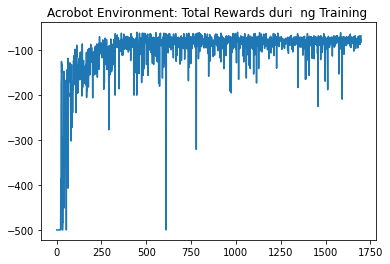

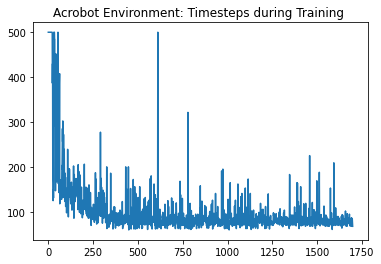

Average reward during testing:  -80.5


<Figure size 432x288 with 0 Axes>

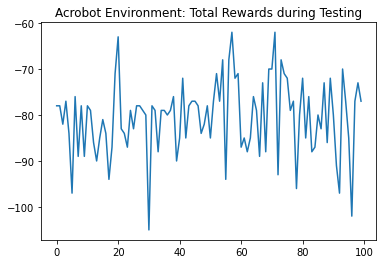

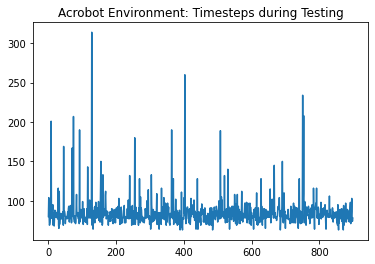

In [110]:
acrobot_obj = gym.make("Acrobot-v1")
main_obj_acrobot = A2C_acrobot(acrobot_obj, 'Acrobot Environment', 6, 3)
main_obj_acrobot.main()

In [113]:
# Saving model weights
main_obj_acrobot.actor_network.save_model("a2c_actor_acrobot.pth")
main_obj_acrobot.critic_network.save_model("a2c_critic_acrobot.pth")

### Load the weights and test the agent

In [115]:
test_agent = A2C_acrobot(acrobot_obj, 'Acrobot Environment', 6, 3)

In [116]:
test_agent.actor_network.load_model("a2c_actor_acrobot.pth")
# test_agent.critic_network.load_model("a2c_critic_acrobot.pth")

Average reward during testing:  -79.88


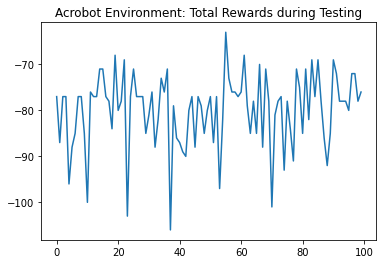

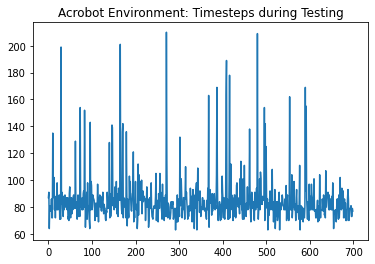

In [118]:
test_agent.test()